In [1]:
import numpy as np

from help_functies import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x_list = []
y_list = []
for i in range(1, 901):
    x_list.append(np.cos(0.1 * i * np.pi / 180))
    y_list.append(np.sin(0.1 * i * np.pi / 180))

In [3]:
ts = np.linspace(0, 1800, 1801)
l = len(ts)
data_np = np.hstack([np.reshape(ts, (l,1)), np.zeros((l, 6))])
data = pd.DataFrame(data_np, columns=['timestamp', 'x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro'])
data['z_gyro'][901:] = np.array([100]*900)
data['x_acc'][:901] = np.ones(901)
data['x_acc'][901:] = x_list
data['y_acc'][901:] = y_list

data.head(2000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
1,1.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
2,2.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
3,3.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
4,4.0,1.000000e+00,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1796,1796.0,6.981260e-03,0.999976,0.0,0.0,0.0,100.0
1797,1797.0,5.235964e-03,0.999986,0.0,0.0,0.0,100.0
1798,1798.0,3.490651e-03,0.999994,0.0,0.0,0.0,100.0
1799,1799.0,1.745328e-03,0.999998,0.0,0.0,0.0,100.0


In [4]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
mb = np.array([1, 0, 0])

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [5]:
q = q11
q_list = [q]

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    omega = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    q = quat_mul(q, expq_omega)
    q_list.append(q)

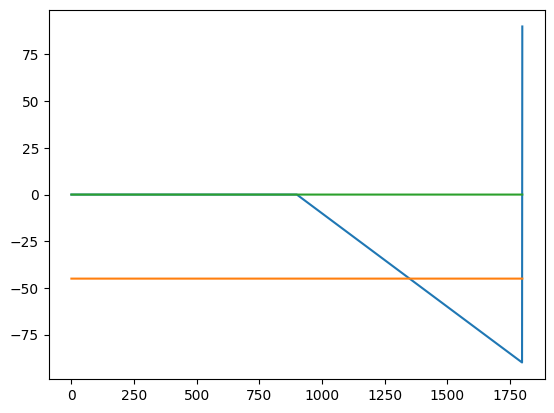

In [6]:
euler_x = []
euler_y = []
euler_z = []

q_norm = []
for q in q_list:
    if np.linalg.norm(q) >= 1:
        q_norm.append(q / 1.00001)
    else:
        q_norm.append(q)

for q in q_norm:
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)

In [7]:
dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11 = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))

In [10]:
qtmin1tmin1 = np.reshape(q11, 4)
Ptmin1tmin1 = P11

v = np.array([0, 0, 0])
p = np.array([0, 0, 0])
q_list = [qtmin1tmin1]
p_list = [p]
v_list = [v]

std_gyro = [0.09748312, 0.06679045, 0.07106568]
std_acc = [0.002165  , 0.00211811, 0.00305338]

Q = np.array([
    [std_gyro[0] ** 2, 0, 0],
    [0, std_gyro[1] ** 2, 0],
    [0, 0, std_gyro[2] ** 2]
])

R = np.array([
    [std_acc[0] ** 2, 0, 0],
    [0, std_acc[1] ** 2, 0],
    [0, 0, std_acc[2] ** 2],
])

epsilon_list = []

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    Ftmin1 = right_quat_mul(expq_omega)
    Gtmin1 = - 0.5 * dt * np.matmul(left_quat_mul(qtmin1tmin1), dqde)

    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)

    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)

    #q0, q1, q2, q3 = quaternion_conjugate(qttmin1)
    q0, q1, q2, q3 = qttmin1
    # Zou kunnen dat hier de geconjugeerde genomen moet worden!!
    # H = np.array([
    #     [2 * q2, 2 * q3, 2 * q0, 2 * q1],
    #     [-2 * q1, -2 * q0, 2 * q3, 2 * q2],
    #     [4 * q0, 0, 0, 4 * q3]
    # ])
    H = np.array([
        [2 * q2, -2 * q3, -2 * q0, -2 * q1],
        [-2 * q1, -2 * q0, 2 * q3, -2 * q2],
        [-4 * q0, 0, 0, -4 * q3]
    ])
    S = np.matmul(np.matmul(H, Pttmin1), H.T) + R
    K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))

    yat = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]]) # - acc_bias
    #yattmin1 = rotate_vector(gn, qttmin1) #quaternion_conjugate(qttmin1)) # Zou kunnen dat hier een min voor moet!!! en geconjugeerde
    yattmin1 = rotate_vector(gn, quaternion_conjugate(qttmin1))
    #yattmin1 = np.array([-2*q1*q3+2*q0*q2, -2*q2*q3-2*q0*q1, -2*q0**2-2*q3**2+1])
    epsilon = yat - yattmin1
    print(data['timestamp'][i], yat, yattmin1)

    q_tt_measure = np.reshape(qttmin1, (4, 1)) + np.matmul(K, np.reshape(epsilon, (3, 1)))
    P_tt_measure = Pttmin1 - np.matmul(np.matmul(K, S), K.T)

    qtt = q_tt_measure / ((np.linalg.norm(q_tt_measure)))
    #J = np.matmul(q_tt_measure, q_tt_measure.T) / (np.linalg.norm(q_tt_measure) ** 3)
    Ptt = P_tt_measure #np.matmul(np.matmul(J, P_tt_measure), J.T) 

    Ptmin1tmin1 = Ptt
    qtmin1tmin1 = np.reshape(qtt, 4)

    q_list.append(qtmin1tmin1)
    epsilon_list.append(epsilon)
    

[[-0.06091879  0.         -0.06092348]
 [ 0.         -0.12184247  0.        ]
 [-0.06092348  0.         -0.06091416]]
1.0 [1. 0. 0.] [ 0.70710678  0.         -0.70710678]
[[ 9.55210687e-06  0.00000000e+00  9.81800260e-07]
 [ 0.00000000e+00 -1.03684447e-02  0.00000000e+00]
 [ 9.81800260e-07  0.00000000e+00  9.52127043e-06]]
2.0 [1. 0. 0.] [ 0.19192148  0.         -0.98141028]
[[ 7.51879468e-06  0.00000000e+00 -7.02088137e-07]
 [ 0.00000000e+00  2.02950855e-05  0.00000000e+00]
 [-7.02088137e-07  0.00000000e+00  9.49721409e-06]]
3.0 [1. 0. 0.] [-0.25694775  0.         -0.9664253 ]
[[ 6.54463448e-06  0.00000000e+00 -1.01758919e-06]
 [ 0.00000000e+00  1.13165783e-05  0.00000000e+00]
 [-1.01758919e-06  0.00000000e+00  9.88072056e-06]]
4.0 [1. 0. 0.] [-0.56376902  0.         -0.8259325 ]
[[ 5.97401871e-06  0.00000000e+00 -9.82212585e-07]
 [ 0.00000000e+00  8.57466160e-06  0.00000000e+00]
 [-9.82212585e-07  0.00000000e+00  1.00735097e-05]]
5.0 [1. 0. 0.] [-0.75119662  0.         -0.66007851]
[

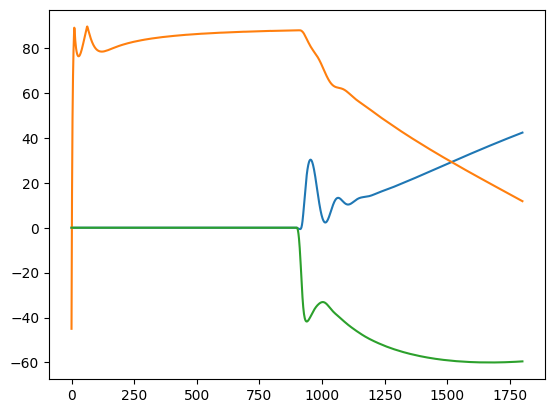

In [11]:
euler_x = []
euler_y = []
euler_z = []

q_norm = []
for q in q_list:
    if np.linalg.norm(q) >= 1:
        q_norm.append(q / 1.00001)
    else:
        q_norm.append(q)

for q in q_norm:
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)